In [71]:
from scipy.constants import m_e, e, c, k
from openpmd_viewer import OpenPMDTimeSeries
import math
import numpy as np

In [72]:
def calculate_temperature( mass, ux, uy, uz ):
    Np = int(len(ux))

    vx_mean = np.sum(ux)*c
    vy_mean = np.sum(uy)*c
    vz_mean = np.sum(uz)*c

    v2 = np.sum(ux**2 + uy**2 + uz**2)*c**2

    invNp = (1. / Np)
    v2 *= invNp
    vx_mean *= invNp
    vy_mean *= invNp
    vz_mean *= invNp
    u_mean2 = vx_mean**2 + vy_mean**2 + vz_mean**2
    udiff = (v2 - u_mean2)
    if udiff < 0.:
        return 0.
    else:
        return (mass / (3. * k)) * udiff

In [73]:
# Plasma properties
n_i = 1e21
n_e = 1e21
Te  = 1000
Ti  = 100

m_i = 4.554691780000000e-30

uth_i = math.sqrt(e * Ti / (m_i * c**2))  # Normalized thermal momenta
uth_e = math.sqrt(e * Te / (m_e * c**2))

# Collision parameters
coulomb_log = 15.9

In [74]:
ts = OpenPMDTimeSeries('./diags/diag1/')
dt = (ts.t[1:]/ts.iterations[1:]).mean()

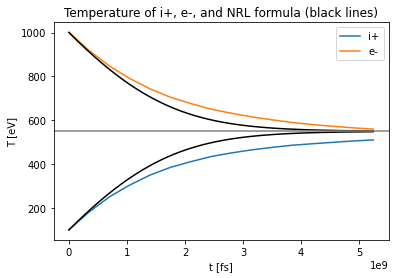

In [75]:

import matplotlib.pyplot as plt
Tmi = np.zeros(len(ts.iterations))
Tme = np.zeros(len(ts.iterations))
l = 0

for i in ts.iterations:
    ux_i = ts.get_particle(['ux'], species='ion', iteration=i)
    ux_e = ts.get_particle(['ux'], species='electron', iteration=i)

    uy_i = ts.get_particle(['uy'], species='ion', iteration=i)
    uy_e = ts.get_particle(['uy'], species='electron', iteration=i)

    uz_i = ts.get_particle(['uz'], species='ion', iteration=i)
    uz_e = ts.get_particle(['uz'], species='electron', iteration=i)


    Tmi[l] = calculate_temperature(m_i, ux_i[0], uy_i[0], uz_i[0])
    Tme[l] = calculate_temperature(m_e, ux_e[0], uy_e[0], uz_e[0])
    l+=1

# NRL relaxation
T_e = Te
T_i = Ti
t_points = 1000
Te_theory = np.zeros(t_points)
Ti_theory = np.zeros(t_points)
Time_plot = ts.iterations[-1] * dt
dtp = Time_plot / t_points
t_array = np.linspace(0, Time_plot, t_points, endpoint=True)
coeff = 1.8e-19 
Zi = 1
Ze = -1
n_i_cgs = n_i / 1000
m_e_cgs = 9.1094e-28
m_i_cgs = 10*m_e_cgs

for i in range(t_points):
    Te_theory[i] = T_e
    Ti_theory[i] = T_i
    nu0 = coeff * Zi**2 * Ze**2 * n_i_cgs * coulomb_log * \
        np.sqrt(m_e_cgs * m_i_cgs) / ((m_e_cgs*T_i + m_i_cgs*T_e)**(3/2)) / 1000
    T_e += nu0 * (T_i - T_e) * dtp
    T_i += nu0 * (T_e - T_i) * dtp

plt.plot(ts.iterations * dt * 1.e15, Tmi * (k/e))
plt.plot(ts.iterations * dt * 1.e15, Tme * (k/e))
plt.plot(t_array * 1.e15, Ti_theory, 'k')
plt.plot(t_array * 1.e15, Te_theory, 'k')
plt.axhline(y=1100/2, color='gray')
plt.legend(["i+", "e-"])
plt.xlabel( 't [fs]' )
plt.ylabel( 'T [eV]' )
plt.title( 'Temperature of i+, e-, and NRL formula (black lines)' )
plt.show()
